In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import csv


In [2]:
# Importing the DATA SET
AddressCount = pd.read_csv("./data/export-AddressCount.csv", index_col=None, header=0)
DAU = pd.read_csv("./data/export-DailyActiveEthAddress.csv", index_col=None, header=0)
MarCap = pd.read_csv("./data/export-MarketCap.csv", index_col=None, header=0)
NetHash = pd.read_csv("./data/export-NetworkHash.csv", index_col=None, header=0)
DailyTx = pd.read_csv("./data/export-TxGrowth.csv", index_col=None, header=0)
Fees = pd.read_csv("./data/export-TransactionFee.csv", index_col=None, header=0)
AVGFee = pd.read_csv("./data/export-AverageDailyTransactionFee.csv", index_col=None, header=0)
RealMC = pd.read_csv("./data/Coin_Metrics_Network_Data_2022-06-27T17-17.csv",  sep = ";", index_col=None, header=0)



AddressCount = AddressCount.rename(columns={"Value":"AddressCount"})
NetHash = NetHash.rename(columns={"Value":"NetHash"})
DailyTx = DailyTx.rename(columns={"Value":"DailyTx"})
Fees = Fees.rename(columns={"Value":"Fees"})

DAU.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('UnixTimeStamp',axis = 1, inplace = True)
AVGFee.drop('DateTime',axis = 1, inplace = True)

frame = pd.concat([AddressCount, DAU,MarCap, NetHash, DailyTx, AVGFee, RealMC[:-10]], axis=1)
frame = frame.T.drop_duplicates().T
frame.drop('Time',axis = 1, inplace = True)
frame['Date(UTC)'] = frame['Date(UTC)'].apply(pd.to_datetime)
frame['newAddressCount'] = frame['AddressCount'].diff()
frame.rename(columns={'ETH / Realized Market Cap (USD)':'rCap'}, inplace=True)
frame = frame [100:]


In [4]:
# Here we delete the column with non number representation (DATE UTC) and make everything float representated 
def cleanData(data):
    result = data.copy().loc[:, frame.columns!='Date(UTC)']
    result = result.loc[:, result.columns!='Price'].astype(float)
    return result

In [5]:
# Here we create s shift function, that can shift the column of the data set how below explained 
# and deletes the exceeding tale (n rows) of the shifted column from the df
#  positive n --> column shifts up (todays metric to future market cap (m : 1,2,3,4,5, c : a,b,c,d) 1->b)
#  negative n --> column shifts down (todays metric to past market cap (m : 1,2,3,4,5, c : a,b,c,d) 2->a)
def shift_(cur, c, n):
    df = cur.copy()
    if (n>0):
        df[c] = df[c].shift(-n)
        return df[:-n]
    elif(n<0):
        df[c] = df[c].shift(-n)
        return df[-n:]
    else:
        return df


In [7]:
# Here we create a map of shift in days -> column with correlations between all other columns to the shifted market cap (Network value)
def corrDict(data, col, r, years):
    arr = {}
    for i in range(r[0], r[1]):
        index = i
        arr[index] = cleanData(shift_(data, col, index).loc[(data['Date(UTC)'].dt.year >= years[0]) & (data['Date(UTC)'].dt.year <= years[1])]).corr()[col]
    return pd.DataFrame.from_dict(arr).T
# TEST
corrDict(frame, 'MarketCap', (-100,100), [2017, 2022])

,UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),rCap,newAddressCount
-100,0.697455,0.765121,0.627017,0.627590,0.501818,0.650373,1.0,0.943451,0.565185,0.658338,NaN,0.935554,0.149814
-99,0.697920,0.765646,0.628540,0.628806,0.503736,0.650799,1.0,0.943481,0.566608,0.660679,NaN,0.936388,0.151770
-98,0.698352,0.766134,0.630393,0.630498,0.505555,0.651197,1.0,0.943366,0.568089,0.663444,NaN,0.937236,0.153709
-97,0.698769,0.766606,0.631968,0.631819,0.507526,0.651582,1.0,0.943335,0.569541,0.666343,NaN,0.938035,0.155526
-96,0.699188,0.767078,0.633327,0.632870,0.509368,0.651969,1.0,0.943321,0.570870,0.670680,NaN,0.938829,0.157206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.725634,0.790748,0.712465,0.716019,0.630941,0.670945,1.0,0.795988,0.708961,0.742172,NaN,0.859215,0.408784
96,0.725621,0.790704,0.712806,0.716629,0.630980,0.670872,1.0,0.794828,0.709650,0.739381,NaN,0.857808,0.409846
97,0.725607,0.790659,0.713206,0.717176,0.630957,0.670799,1.0,0.793893,0.710087,0.735802,NaN,0.856489,0.411323
98,0.725593,0.790614,0.713201,0.717583,0.630283,0.670726,1.0,0.792726,0.710260,0.732333,NaN,0.855135,0.412072


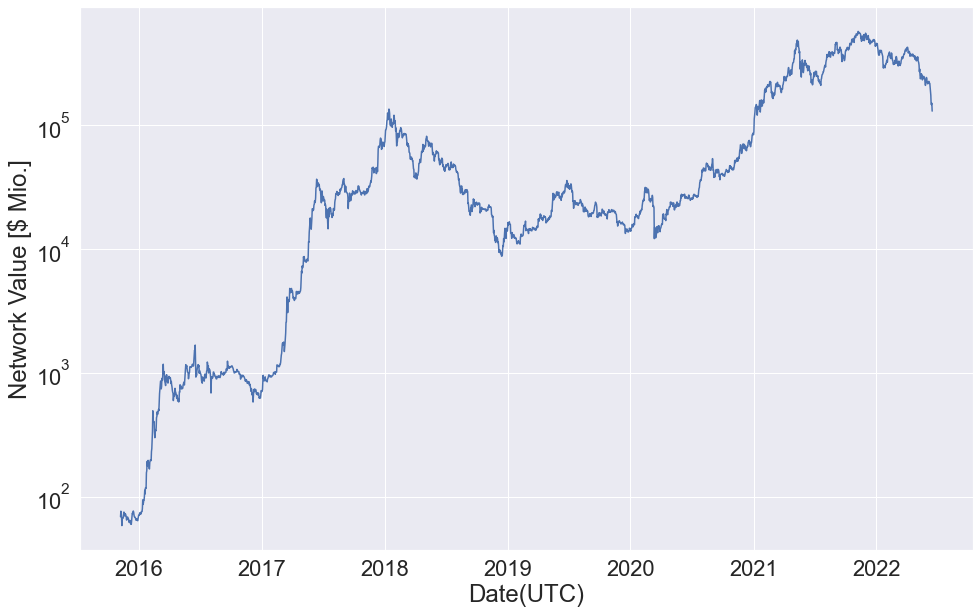

In [8]:
# Plot network value to date utc
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(16,10))
ax.set(yscale="log")

p = sns.lineplot(data = frame, y = 'MarketCap', x= 'Date(UTC)', ax = ax)
p.set_ylabel("Network Value [$ Mio.]")
name = 'finals/NetworkValue.png'
# fig.savefig(name, transparent = False)

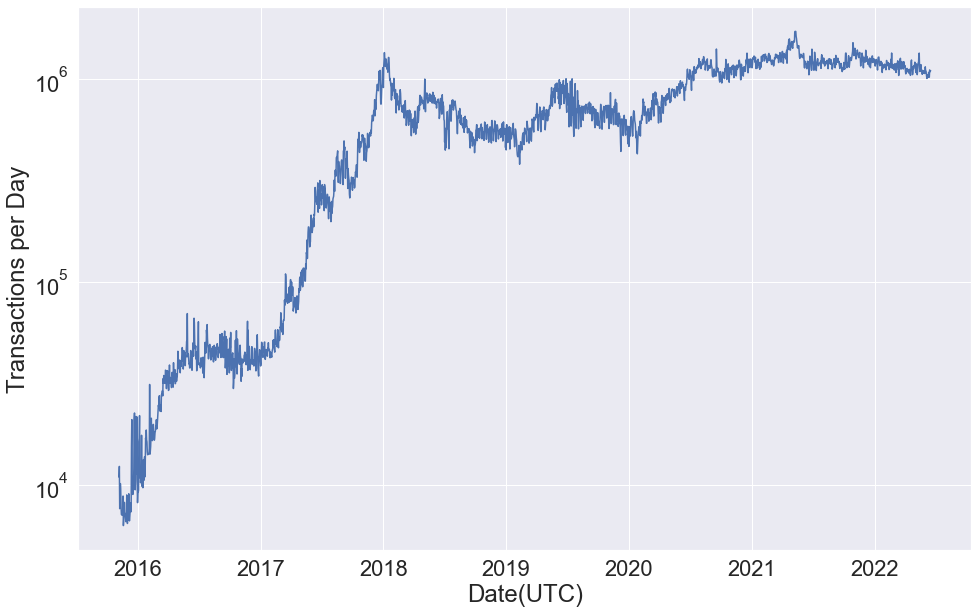

In [9]:
# Plot DailyTx (Transactions per day) to date utc
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(16,10))
ax.set(yscale="log")

p = sns.lineplot(data = frame, y = 'DailyTx', x= 'Date(UTC)', ax = ax)
p.set_ylabel('Transactions per Day')
name = 'finals/Transactions.png'
# fig.savefig(name, transparent = False)

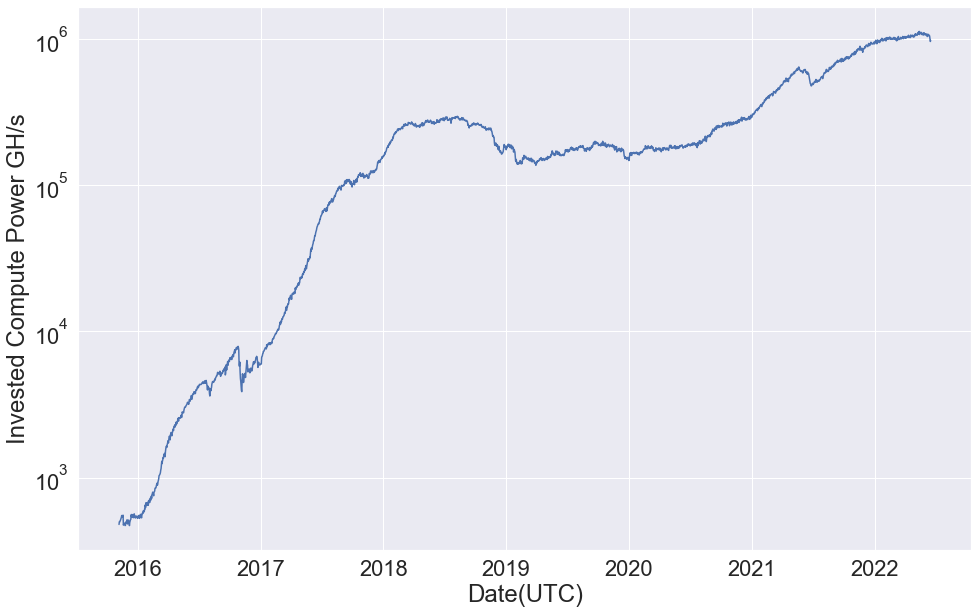

In [10]:
# Plot Nethash(Invested compute power) to data utc
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(16,10))
ax.set(yscale="log")

p = sns.lineplot(data = frame, y = 'NetHash', x= 'Date(UTC)', ax = ax)
p.set_ylabel('Invested Compute Power GH/s')
name = 'finals/Energy.png'
# fig.savefig(name, transparent = False)

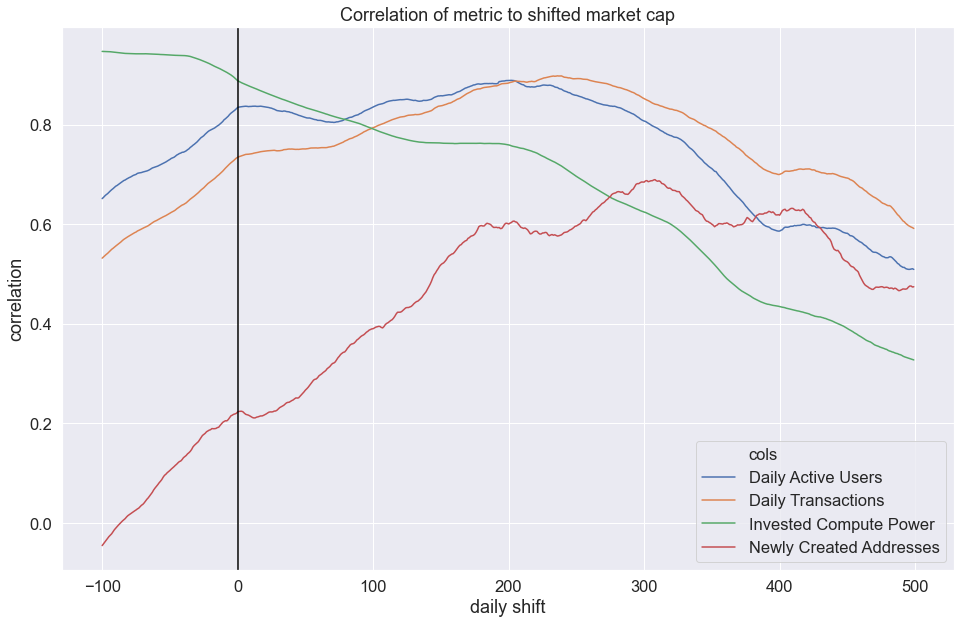

In [13]:
# Here we create percent change for every metric and save it to pc_frame
# then we update the correlation dictionary and after use it to manually recreate 
# the correlation of metric's percent change to percent change of market cap (network value) sifted by n days to the future
metrics = ["Unique Address Total Count","DailyTx", 'NetHash', "MarketCap", "newAddressCount"]
pc_metrics = ['Date(UTC)']
ft = [100,-1]
pc_frame = frame[ft[0]:ft[1]].copy()
for metric in metrics:
    name = metric + '_perchange'
    pc_metrics.append(name)
    pc_frame[name] = pc_frame[metric].diff().cumsum() / pc_frame[metric].iloc[0]

def corrDictionary(data, col, r):
    # frame[['Unique Address Total Count','MarketCap']]
    arr = {}
    for i in range(r[0], r[1]):
        # cur = pd.concat([shift_(tmp, 'MarketCap', i).corr()['MarketCap'],cur], axis = 1)
        index = i
        arr[index] = shift_(data, col, index).astype(float).corr()[col] 
    # cur.copy().loc[:, frame.columns!='Date(UTC)']
    return pd.DataFrame.from_dict(arr).T
ss = -100
se = 500
sns.set(font_scale = 1.5)
targ_cols = ['Unique Address Total Count_perchange', 'DailyTx_perchange', 'NetHash_perchange', 'MarketCap_perchange', 'newAddressCount_perchange']
targ_cols
target_col = 'MarketCap_perchange'
targ_frame = pc_frame[targ_cols][1000:]
pc_dict = corrDictionary(targ_frame, target_col, [ss,se])[['Unique Address Total Count_perchange', 'DailyTx_perchange','NetHash_perchange', 'newAddressCount_perchange']]
coltshow = ["Daily Active Users", "Daily Transactions", "Invested Compute Power", "Newly Created Addresses"]
pc_dict[coltshow[0]] = pc_dict["Unique Address Total Count_perchange"]
pc_dict[coltshow[1]] = pc_dict["DailyTx_perchange"]
pc_dict[coltshow[2]] = pc_dict["NetHash_perchange"]
pc_dict[coltshow[3]] = pc_dict["newAddressCount_perchange"]
pc_dict = pc_dict[coltshow]
arr_m = pc_dict.reset_index().melt('index', var_name = 'cols', value_name = 'vals')
fig, ax = plt.subplots(figsize=(16,10))
plot = sns.lineplot(data = arr_m, x = 'index', y = 'vals',ax = ax, hue='cols', palette = 'deep')
plot.set(xlabel='daily shift', ylabel='correlation', title='Correlation of metric to shifted market cap')
plot.axvline(0, color= 'black')
name = 'finals/>2018_correlation_all.png'
# fig.savefig(name, transparent = False)


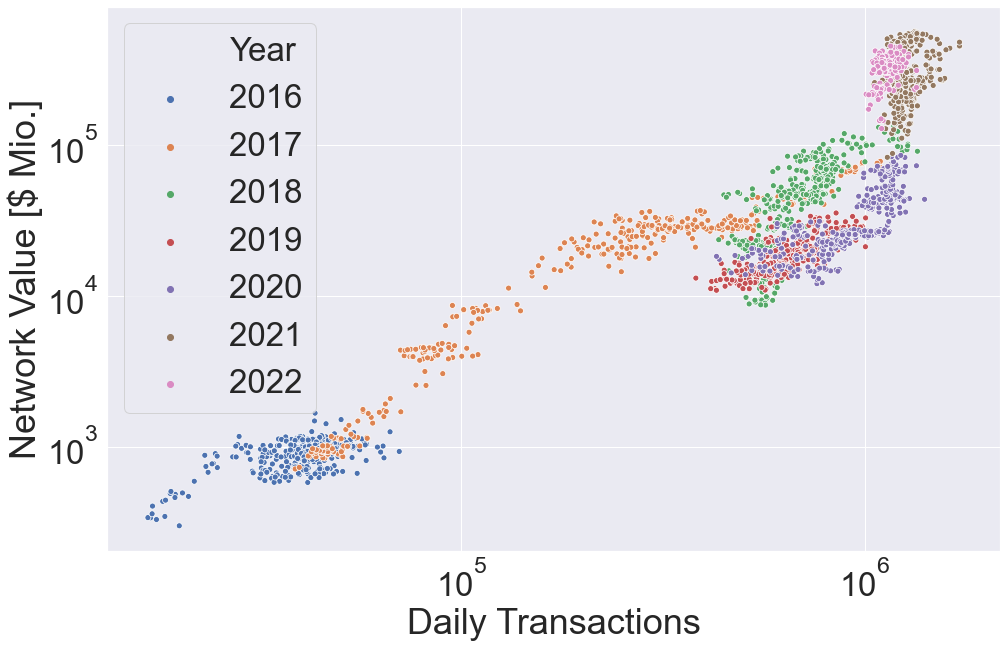

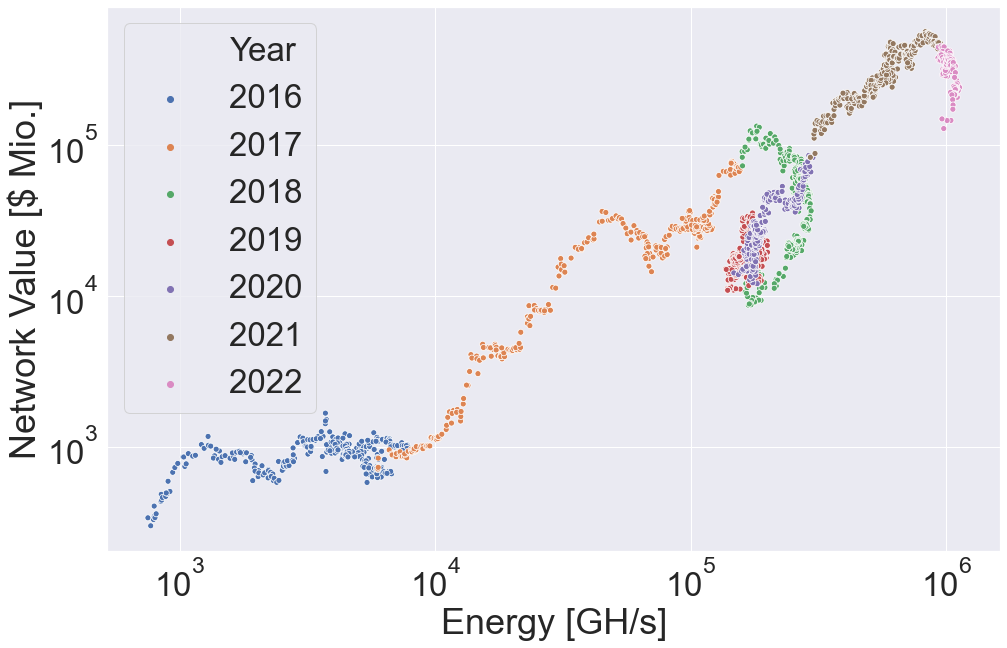

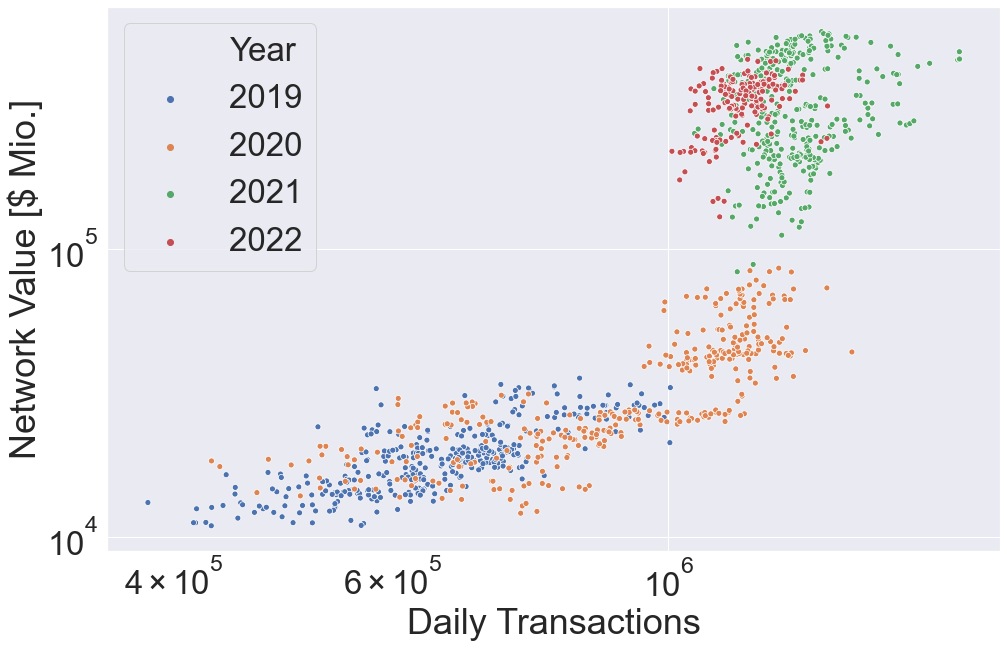

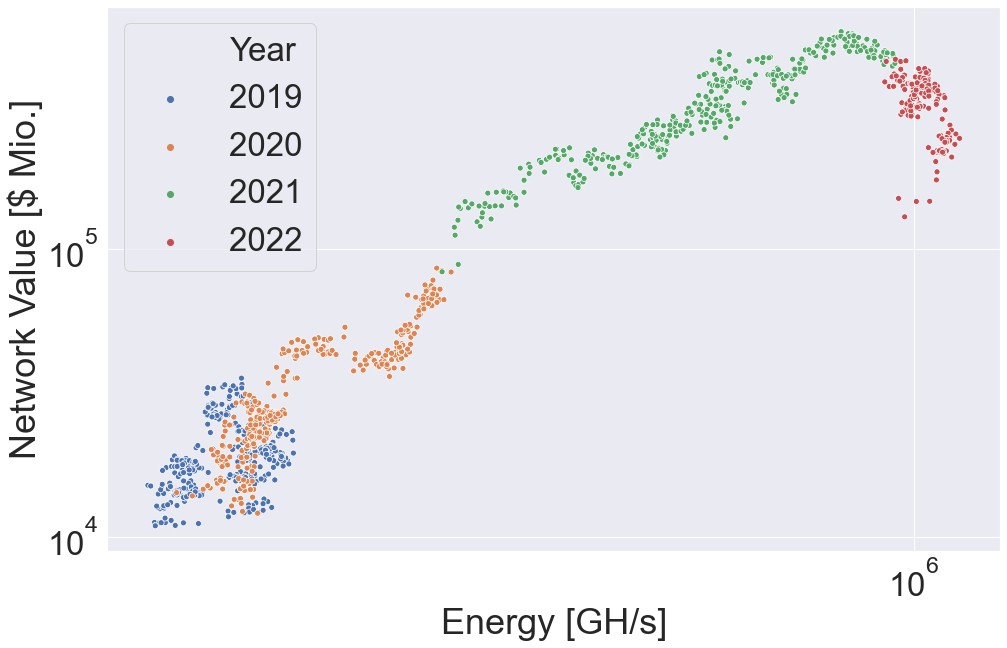

In [31]:
# here we create a correlation scatterplot between network value and
# our expected two metrics once for all years and once for >2018
import math
metrics = ["DailyTx", 'NetHash']
target = frame[100:].copy()
target["Year"] = target["Date(UTC)"].dt.year
# target = target[target["Year"] > 2018]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set(yscale="log", xscale = "log")
    p = sns.scatterplot(data = shift_((target),'MarketCap', 0), x = metric, y = "MarketCap", hue="Year", palette="deep")
    plmetr = metric
    if (metric == "Unique Address Total Count"):
        plmetr = "Daily Unique Addresses"
    if (metric == "NetHash"):
        plmetr = "Energy [GH/s]"
    if (metric == "DailyTx"):
        plmetr = "Daily Transactions"
    plot.set(xlabel=plmetr, ylabel= plmetr, title=plmetr + ' vs Metwork Value (log scale)' )
    p.set_ylabel("Network Value [$ Mio.]")
    p.set_xlabel(plmetr)

    name = 'finals/' + 'shifted_MarketCap_vs_' + str(metric)+'_log.png'
    # fig.savefig(name, transparent = False)


target = target[target["Year"] > 2018]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set(yscale="log", xscale = "log")
    p = sns.scatterplot(data = shift_((target),'MarketCap', 0), x = metric, y = "MarketCap", hue="Year", palette="deep")
    plmetr = metric
    if (metric == "Unique Address Total Count"):
        plmetr = "Daily Unique Addresses"
    if (metric == "NetHash"):
        plmetr = "Energy [GH/s]"
    if (metric == "DailyTx"):
        plmetr = "Daily Transactions"
    plot.set(xlabel=plmetr, ylabel= plmetr, title=plmetr + ' vs Metwork Value (log scale)' )
    p.set_ylabel("Network Value [$ Mio.]")
    p.set_xlabel(plmetr)

    name = 'finals/' + '>2018_shifted_MarketCap_vs_' + str(metric)+'_log.png'

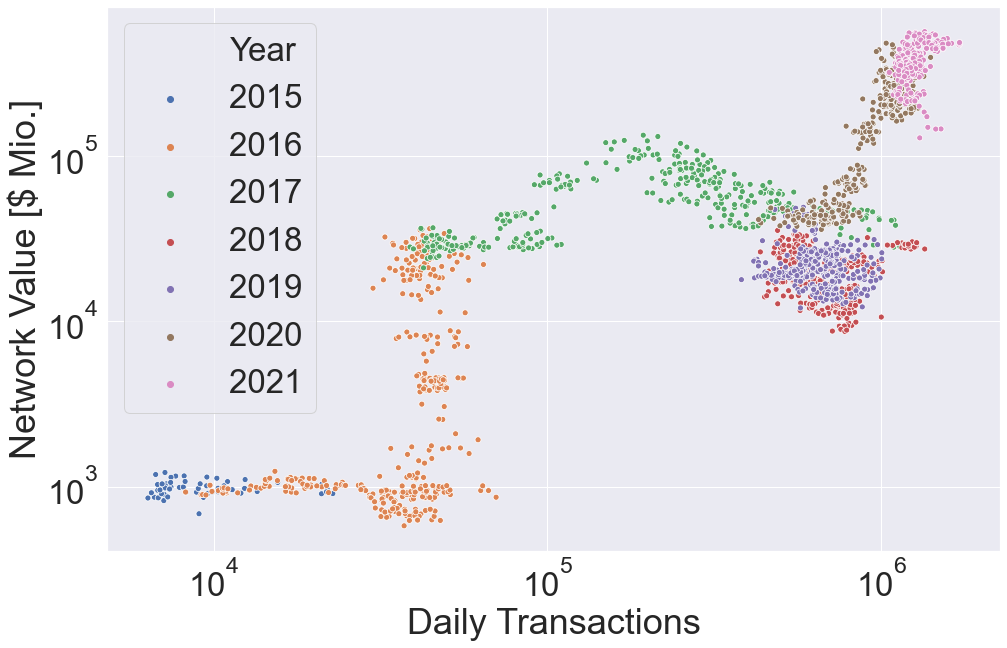

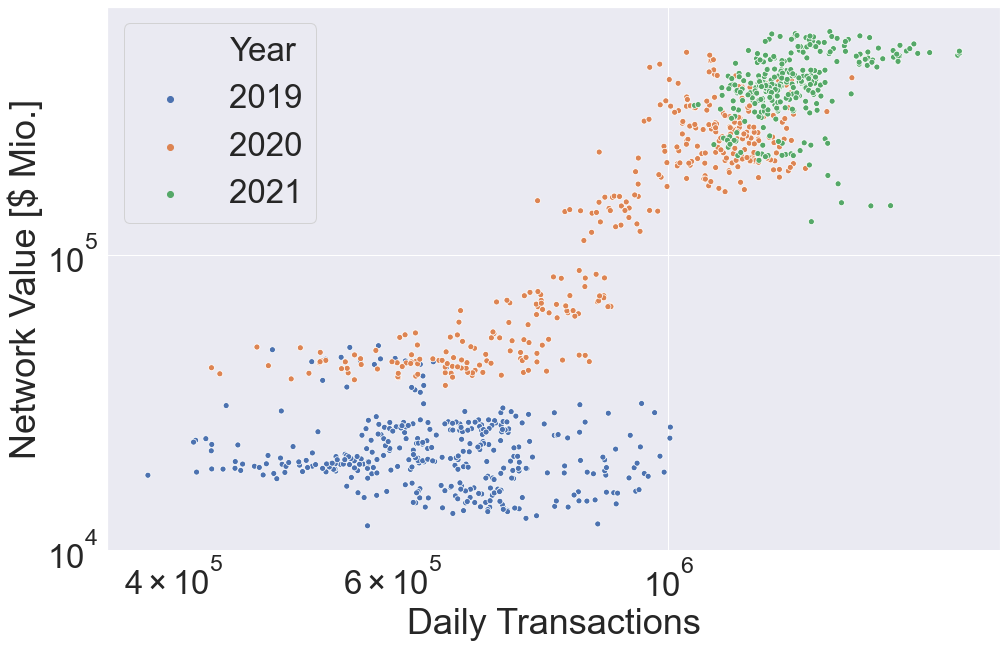

In [27]:
# here we create a correlation scatterplot between network value shifted to the future for 228 days 
# and our daily transactions  once for all years and once for >2018
import math
metrics = ["DailyTx"]
target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
# target = target[target["Year"] > 2018]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set(yscale="log", xscale = "log")
    p = sns.scatterplot(data = shift_((target),'MarketCap', 228), x = metric, y = "MarketCap", hue="Year", palette="deep")
    plmetr = metric
    if (metric == "Unique Address Total Count"):
        plmetr = "Daily Unique Addresses"
    if (metric == "NetHash"):
        plmetr = "Energy [GH/s]"
    if (metric == "DailyTx"):
        plmetr = "Daily Transactions"
    plot.set(xlabel=plmetr, ylabel= plmetr, title=plmetr + ' vs Metwork Value (log scale)' )
    p.set_ylabel("Network Value [$ Mio.]")
    p.set_xlabel(plmetr)

    name = 'finals/' + 'shifted_MarketCap_vs_' + str(metric)+'_log.png'
    # fig.savefig(name, transparent = False)


target = target[target["Year"] > 2018]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set(yscale="log", xscale = "log")
    p = sns.scatterplot(data = shift_((target),'MarketCap', 228), x = metric, y = "MarketCap", hue="Year", palette="deep")
    plmetr = metric
    if (metric == "Unique Address Total Count"):
        plmetr = "Daily Unique Addresses"
    if (metric == "NetHash"):
        plmetr = "Energy [GH/s]"
    if (metric == "DailyTx"):
        plmetr = "Daily Transactions"
    plot.set(xlabel=plmetr, ylabel= plmetr, title=plmetr + ' vs Metwork Value (log scale)' )
    p.set_ylabel("Network Value [$ Mio.]")
    p.set_xlabel(plmetr)

    name = 'finals/' + '>2018_shifted_MarketCap_vs_' + str(metric)+'_log.png'

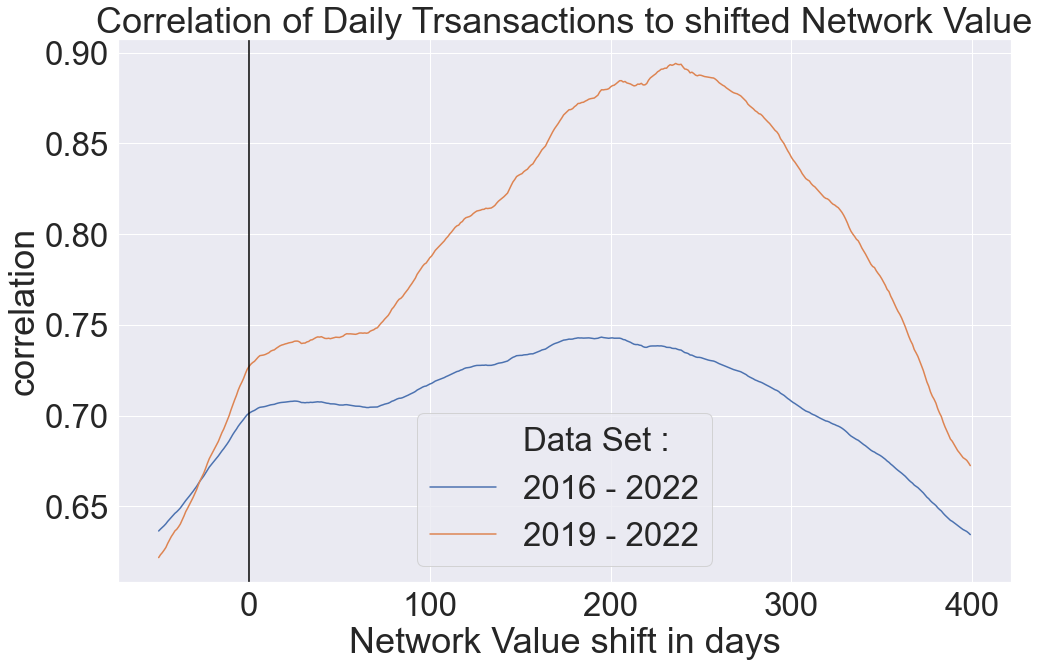

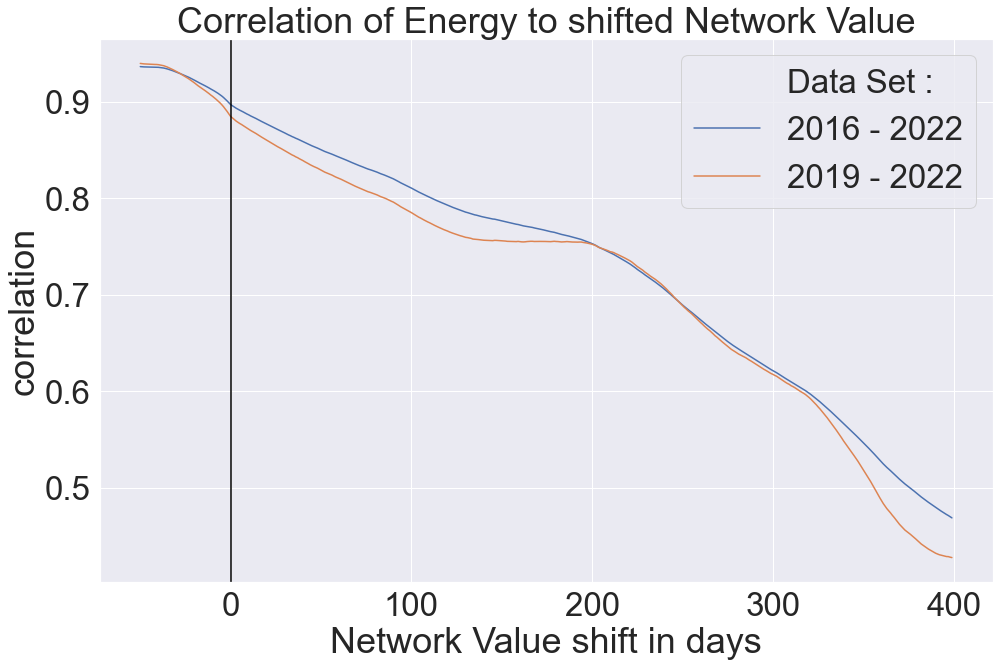

In [29]:
# here we plot the correlation data of the metric to shifted market cap for different shifts
ss = -50
se = 400
metrics = ['DailyTx', 'NetHash']

for metric in metrics:
    dict = {}
    for j in range(0,2):
        n = 2016 + j*3
        condition = [n, 2022]
        d_name = str(n) + ' - 2022'
        # arr = corrDict(frame[:], 'MarketCap', (ss,se), condition)[metric].reset_index()
        dict[d_name] = corrDict(frame[:], 'MarketCap', (ss,se), condition)[metric]
    arr = pd.DataFrame.from_dict(dict)
    arr

    # name = 'shifted_marketcap/correlation_shifted_' + str(condition) + ' :' + str(ss) + ',' + str(se) + '.png'
    # fig.savefig(name, transparent = False)

    arr_m = arr.reset_index().melt('index', var_name = 'Data Set :', value_name = 'vals')
    fig, ax = plt.subplots(figsize=(16,10))
    plot = sns.lineplot(data = arr_m, x = 'index', y = 'vals',ax = ax, hue='Data Set :')
    plmetric = metric
    if (metric == 'DailyTx'):
        plmetric = 'Daily Trsansactions'
    if (metric == 'NetHash'):
        plmetric = 'Energy'   
    plot.set(xlabel='Market Cap shift in days', ylabel='correlation', title='Correlation of '+ plmetric +' to shifted Network Value')
    plot.set_xlabel('Network Value shift in days')
    plot.axvline(0, color= 'black')

    name = 'finals/correlation_shifted_' + metric + '.png'
    # fig.savefig(name, transparent = False)
